In [51]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNet, MobileNetV2


In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/Project Capstone'

In [53]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset/valid'
print(f"Data Directory: {os.listdir(data_validation)}")


Base Directory: ['train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


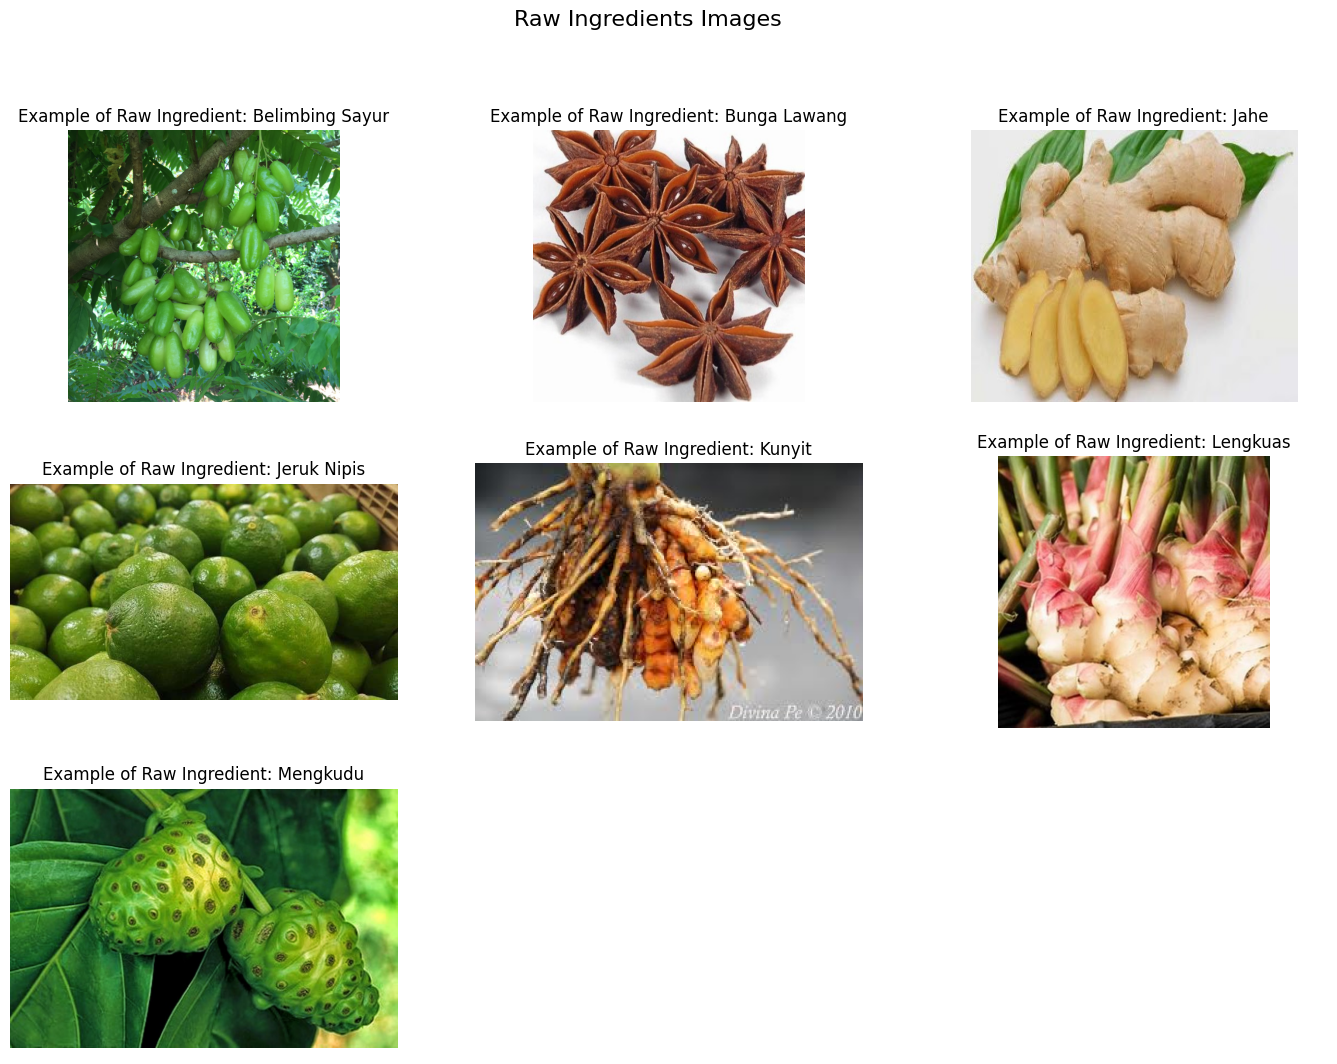

In [54]:
# Plot Raw Ingredient Images
fig, axes = plt.subplots(3, 3, figsize=(17, 12))
fig.suptitle('Raw Ingredients Images', fontsize=16)

# List of Ingredients
ingredients_list = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
# Plot images for each ingredient
for ii, ingredient in enumerate(ingredients_list):
    dir_path = f'./Dataset/train/{ingredient}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, 3)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of Raw Ingredient: {ingredient}')
    axes[row, col].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(ingredients_list), 9):
    row, col = divmod(jj, 3)
    axes[row, col].axis('off')

plt.show()

In [64]:
# Define constants
BATCH_SIZE = 32  # Set your batch size
NUM_CLASSES = 7  # Set the number of classes
CLASS_MODE='categorical'

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)



In [79]:
# Use binary class mode for multi-label classification
train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)

validation_generator = test_datagen.flow_from_directory(
    data_validation,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)


Found 2055 images belonging to 7 classes.
Found 487 images belonging to 7 classes.


In [67]:
# Load the pre-trained MobileNetV2 model
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False


In [68]:
def based_model2():
    model = tf.keras.models.Sequential([
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')  # Change to sigmoid for multi-label
    ])
    return model


In [69]:
model = based_model2()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,287,175 (39.24 MB)

 Trainable params: 8,029,191 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
# Compile the model with binary crossentropy loss
model.compile(loss='binary_crossentropy',  # Change to binary_crossentropy
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])


In [71]:
# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [72]:
epoch = 100
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=epoch, 
                    validation_data=validation_generator, 
                    shuffle=True,
                    callbacks=[EarlyStoppingCallback()])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
49/65 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5210 - loss: 1.4747

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5572 - loss: 1.2666 - val_accuracy: 0.9035 - val_loss: 0.0870
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 60s 925ms/step - accuracy: 0.8193 - loss: 0.1609 - val_accuracy: 0.9405 - val_loss: 0.0616
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 58s 899ms/step - accuracy: 0.8499 - loss: 0.1348 - val_accuracy: 0.9589 - val_loss: 0.0420
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 58s 893ms/step - accuracy: 0.8525 - loss: 0.1276 - val_accuracy: 0.9384 - val_loss: 0.0523
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 901ms/step - accuracy: 0.8642 - loss: 0.1132 - val_accuracy: 0.9384 - val_loss: 0.0470
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 902ms/step - accuracy: 0.8837 - loss: 0.1060 - val_accuracy: 0.9405 - val_loss: 0.0506
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 952ms/step - accuracy: 0.9047 - loss: 0.0854 - val_accuracy: 0.9487 - val_loss: 0.0498
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 964ms/step - accuracy: 0.8667 - loss: 0.1011 - val_accuracy: 0

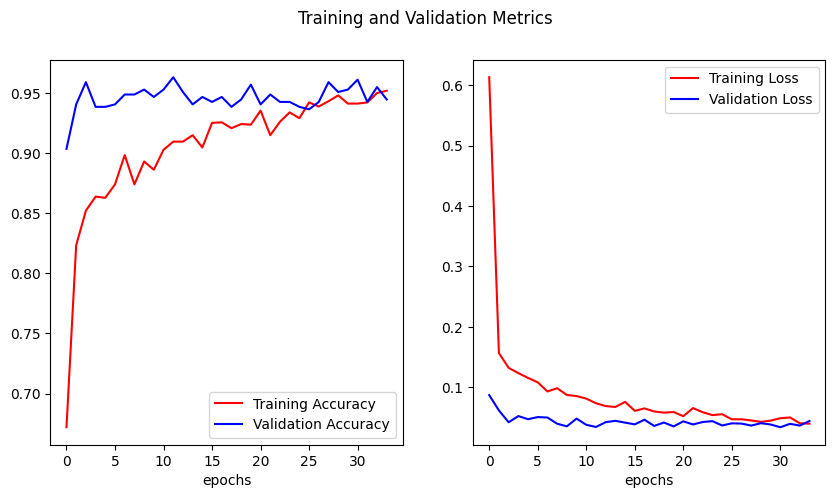

In [73]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [81]:
save_dir = r'Dataset'
model_name = 'LokaJamu'
subject = 'LokaJamu'

# Simplified and more descriptive variable names
num_test_files = sum([len(files) for r, d, files in os.walk(data_validation)])
num_test_steps = num_test_files // 32

# Evaluate the model and print the message
test_datagen = ImageDataGenerator(rescale=1./255)  # Adjust preprocessing as needed
test_generator = test_datagen.flow_from_directory(
    data_validation,
    target_size=(224, 224),  # replace with your model's input dimensions
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='sparse')
acc = model.evaluate(validation_generator, batch_size=BATCH_SIZE, verbose=1, steps=num_test_steps)[1] * 100
print(f"Accuracy on the test set is {acc:.2f} %")

# Save the model
model_id = f"{model_name}-{subject}.h5"

# Check if the directory exists, if not, create it
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

model.save('lokajamu_model.h5')

# pickle.dump(model,open(model_id,"wb"))


Found 487 images belonging to 7 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step - accuracy: 0.9424 - loss: 0.0427


Accuracy on the test set is 94.58 %


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step


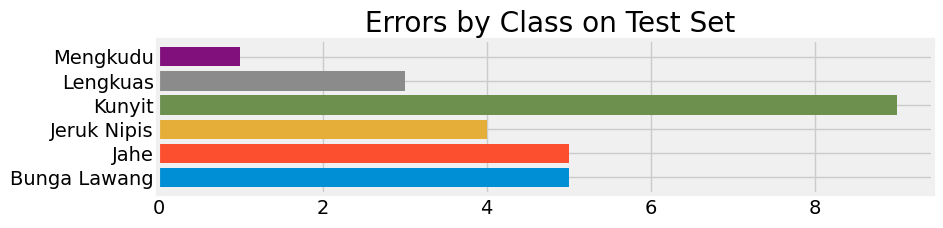

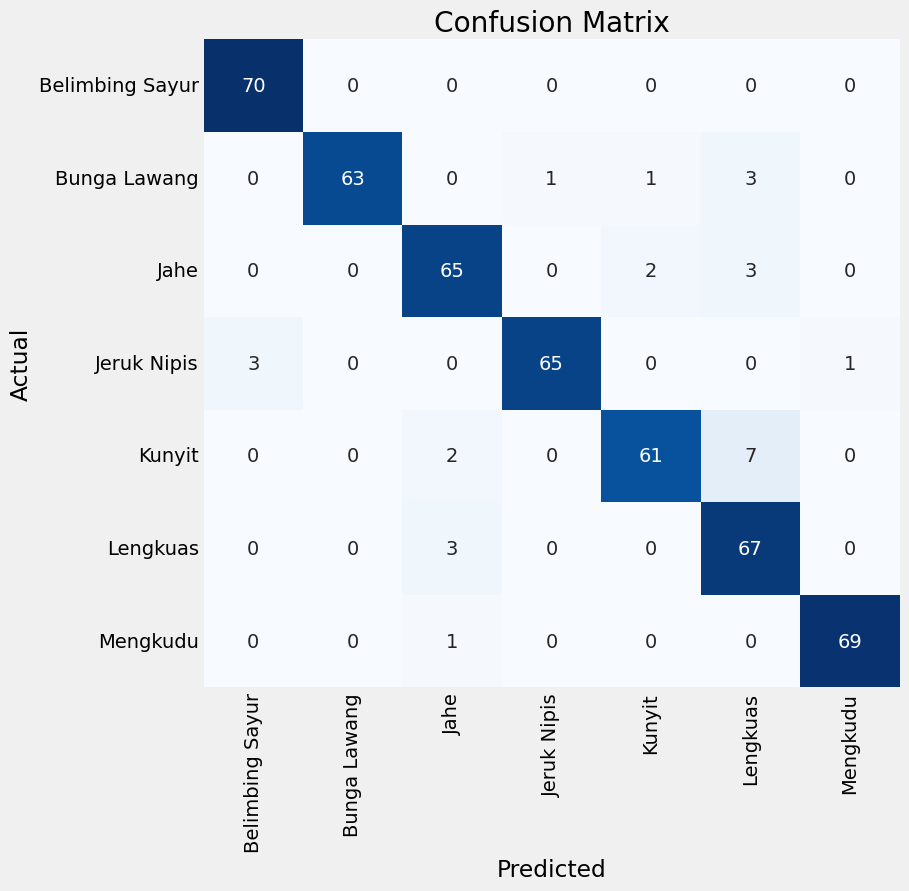

NameError: name 'classification_report' is not defined

In [82]:
print_code=0
preds=model.predict(test_generator)
print_info( test_generator, preds, print_code, save_dir, subject )